In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
# 将图片数据从 [0,1] 归一化为 [-1, 1] 的取值范围
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


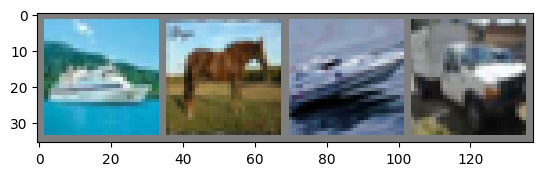

 ship horse  ship truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 展示图片的函数
def imshow(img):
    img = img / 2 + 0.5     # 非归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取训练集图片
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 展示图片
imshow(torchvision.utils.make_grid(images))
# 打印图片类别标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
import torch.optim as optim

# 设置交叉熵损失函数
criterion = nn.CrossEntropyLoss()
# 启用带有动量的 SGD 优化
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
import time
start = time.time()
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入数据
        inputs, labels = data
        # 清空梯度缓存
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:
            # 每 2000 次迭代打印一次信息
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training! Total cost time: ', time.time()-start)

[1,  2000] loss: 1.241
[1,  4000] loss: 1.235
[1,  6000] loss: 1.226
[1,  8000] loss: 1.238
[1, 10000] loss: 1.202
[1, 12000] loss: 1.210
[2,  2000] loss: 1.135
[2,  4000] loss: 1.141
[2,  6000] loss: 1.167
[2,  8000] loss: 1.119
[2, 10000] loss: 1.137
[2, 12000] loss: 1.127
Finished Training! Total cost time:  76.33497714996338


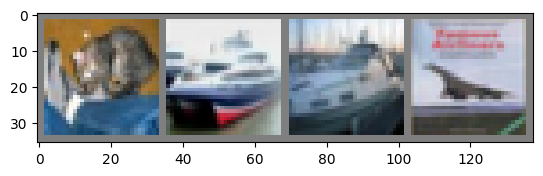

GroundTruth:    cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 打印图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [15]:
# 网络输出
outputs = net(images)

# 预测结果
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship plane  ship


In [16]:
# 模型准确度测试
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [17]:
# 各个分类的预测准确度测试
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 64 %
Accuracy of  bird : 43 %
Accuracy of   cat : 36 %
Accuracy of  deer : 57 %
Accuracy of   dog : 48 %
Accuracy of  frog : 67 %
Accuracy of horse : 65 %
Accuracy of  ship : 70 %
Accuracy of truck : 77 %


In [19]:
# 在gpu上进行训练
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import time
# 在 GPU 上训练注意需要将网络和数据放到 GPU 上
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

start = time.time()
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入数据
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 清空梯度缓存
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:
            # 每 2000 次迭代打印一次信息
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training! Total cost time: ', time.time() - start)

cuda:0
[1,  2000] loss: 1.047
[1,  4000] loss: 1.083
[1,  6000] loss: 1.082
[1,  8000] loss: 1.058
[1, 10000] loss: 1.083
[1, 12000] loss: 1.091
[2,  2000] loss: 0.999
[2,  4000] loss: 0.996
[2,  6000] loss: 1.002
[2,  8000] loss: 1.043
[2, 10000] loss: 1.027
[2, 12000] loss: 1.022
Finished Training! Total cost time:  104.03444337844849


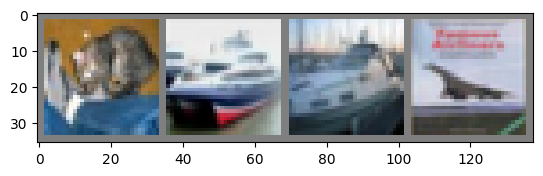

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship


In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 打印图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# gpu网络输出
images = images.to(device)
outputs = net(images)

# 预测结果
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
